# CC5215: Privacidad de Datos
## Laboratorio 4

Integrantes:

- Nombre: Francisco Gutiérrez Albornoz

In [2]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')
adult = adult.dropna()

In [2]:
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Question 1 (10 points)

As you can imagine, the column Capital Gain does not have an obvious upper bound. Therefore, in order to compute a differentially private sum of that column, we need to clip the column.

Complete the function `find_sensitivity_clipping_cgain` that plots the sum of 'Capital Gain' for different clipping parameters. Your function should not use more of a privacy budget than `epsilon`.

_Hint_: Explore different cliping parameters using a step of `10000` and a reasonable number of iterations.

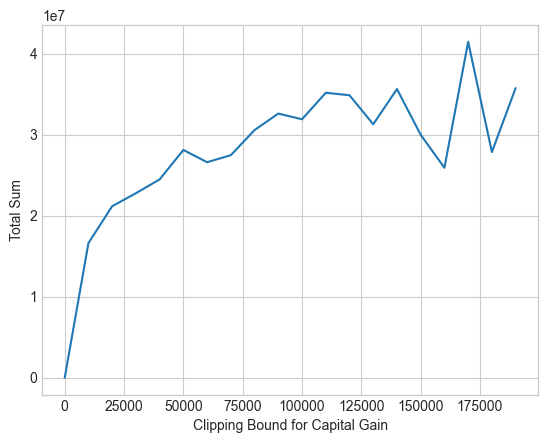

In [6]:
def find_sensitivity_clipping_cgain(epsilon):
    n=20#35
    step = 10000
    range_CG = range(0, step * n, step)
    result_list = [laplace_mech(adult['Capital Gain'].clip(lower=0, upper=i).sum(), i, epsilon/n) for i in range_CG]
    plt.plot(range_CG, result_list)
    plt.xlabel('Clipping Bound for Capital Gain')
    plt.ylabel('Total Sum')

# You will propably want to use this latter 👀
CLIPPING_EPSILON = 1.0

find_sensitivity_clipping_cgain(CLIPPING_EPSILON)

In [3]:
# Define this variable for the next question

CAPGAIN_UPPER_BOUND = 110000

### Question 2 (10 points)

- What is a reasonable clipping parameter? and why?
- What was the privacy budget (`epsilon`) for each iteration?


- ANSWER 1: Yo escogí 110000 como un parámetro razonable ya que en el gráfico se observa que un poco después de 100000 la curva tienden a 'oscilar' entre 3 y 4 (10^7). Al considerar un rango posterior de 175000 las oscilaciones eran más abruptas y no tenían un valor en torno al cual se mantuvieran. Esto lo podríamos corroborar generando un fiteo de la curva para tener un comportamiento un poco más suave.
- ANSWER 2: En cada iteración se utilizó epsilon/n con n el número total de iteraciones. En este caso como eran 20 oscilaciones, se utilizó el 5% del epsilon en cada iteración.


### Question 3 (10 points)

Complete the definition of `dp_sum_capgain` below, using the clipping parameter you previously found. Your definition should compute a differentially private sum of the "Capital Gain" column of the `adult` dataset, and have a total privacy cost of `epsilon`.

_Hint_: Remember that you already used some of the privacy budget for finding the clipping parameter.

In [9]:
def dp_sum_capgain(epsilon):
    eps_sum = epsilon - CLIPPING_EPSILON
    return laplace_mech(adult['Capital Gain'].clip(lower=0, upper=CAPGAIN_UPPER_BOUND).sum(), CAPGAIN_UPPER_BOUND, eps_sum)

dp_sum_capgain(2.0)

np.float64(32942004.236387853)

In [10]:
# TEST CASES for question 3

real_sum = adult['Capital Gain'].sum()
r1 = np.mean([pct_error(real_sum, dp_sum_capgain(2.0)) for _ in range(100)])
r2 = np.mean([pct_error(real_sum, dp_sum_capgain(10.0)) for _ in range(100)])
r3 = np.mean([pct_error(real_sum, dp_sum_capgain(40.0)) for _ in range(100)])

print("Average errors:", r1, r2, r3)

assert r1 > 0
assert r2 > 0
assert r3 > 0
assert r1 < 0.5
assert r2 < 0.05
assert r3 < 0.01

Average errors: 0.274864215114566 0.034099707526153544 0.009036889452012843


### Question 4 (10 points)

In 2-5 sentences each, answer the following:

- What was the sensitivity of the query you used in `dp_sum_capgain`, and how is it bounded?
- Argue that your definition of `dp_sum_capgain` has a total privacy cost of `epsilon`
- Is it necessary to do the sum again after computing the `CAPGAIN_UPPER_BOUND`? Can we do better?

- ANSWER 1: La sensibilidad utilizada fue lo almacenado en la variable `CAPGAIN_UPPER_BOUND` (110000) ya que es el mayor valor considerado para el Capital Gain, por tanto es la máxima variación que se podría tener al considerar un elemento más en la suma.
- ANSWER 2: Para el clipping se utiliza `CLIPPING_EPSILON`, luego para la suma se utiliza `epsilon_sum`. Como estas operaciones son sobre el mismo input, utilizamos composición secuencial. De esta forma el costo de privacidad total es la suma de ambos. En la función definida anteriormente, se puede observar que esta suma es `epsilon`.
- ANSWER 3: Es necesario hacerlo luego del clipping ya que de no ser así, la sensibilidad sería mayor (posiblemente infinita al no estar acotado). Debido a esto el ruido necesario para garantizar privacidad sería mayor lo que genera una pérdida de uso en la información.

### Question 5 (10 points)

Complete the definition of `dp_avg_capgain` below. Your definition should compute a differentially private average (mean) of the "Capital Gain" column of the adult dataset, and have a **total privacy cost of epsilon**.

_Hint_: Use 10% of the privacy budget for computing the count, and the rest for the sum

In [106]:
def dp_avg_capgain(epsilon):
    count_CG = laplace_mech(len(adult['Capital Gain']), 1, 0.1 * epsilon)
    sum_CG = dp_sum_capgain(0.9 * epsilon)
    return sum_CG/count_CG
dp_avg_capgain(2.0)

np.float64(1092.1104961406172)

In [108]:
# TEST CASE for question 5

real_avg = adult['Capital Gain'].mean()
r1 = np.mean([pct_error(real_avg, dp_avg_capgain(2.0)) for _ in range(100)])
r2 = np.mean([pct_error(real_avg, dp_avg_capgain(10.0)) for _ in range(100)])
r3 = np.mean([pct_error(real_avg, dp_avg_capgain(40.0)) for _ in range(100)])

print("Average errors:", r1, r2, r3)

assert r1 > 0
assert r2 > 0
assert r3 > 0
assert r1 < 0.5
assert r2 < 0.05
assert r3 < 0.01

Average errors: 0.01638132767126032 0.0032986944118939066 0.0008428253032781606


### Question 6 (10 points)

In 2-5 sentences each, answer the following:

- Argue that your definition of `dp_avg_capgain` has a total privacy cost of `epsilon`
- For sums and averages, which seems to be more important for accuracy - the value of the clipping parameter $b$ or the scale of the noise added? Why?
- Do you think the answer to the previous point will be true for every dataset? Why or why not?

- ANSWER 1: Como las operaciones se realizan sobre el mismo input, utilizamos composición secuencial por ende sumamos los epsilon utilizados (10% + 90% de epsilon).
- ANSWER 2: Ambos puenden influir en la precisión, pero el parámetro de clipping puede influir más ya que es posible que al escoger una mala cota se pierda información importante.
- ANSWER 3: No, en aquellos dataset que se tenga información adicional (o que los datos estén muy concentrados) de forma que los límites a considerar sean evidentes, una mayor precisión estará condicionada principalmente en la cantidad de ruido que se agregue.

### Question 7 (10 points)

Write a function `dp_age_hist` that plots a histogram for the column Age where the count is performed in a differentially private manner. The histogram should show 10 bins.

_Hint 1_: Do not use the function `.hist()` directly. Instead, compute the count for each bin, make it private, and the use `.plot(kind='bar')`

_Hint 2_: You can use the parameter `bins=[n1, ..., n]` of the method `value_counts` to count the values of a column within bins of size 10, from 0 to 150

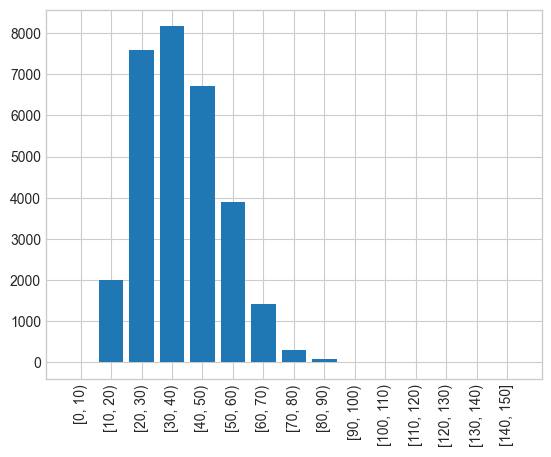

In [11]:
def dp_age_hist(epsilon):
    vc_Age = adult['Age'].value_counts(bins=[i for i in range(0, 151, 10)])
    print()
    age_dp = []
    for value in vc_Age.sort_index(): 
        age_dp.append(laplace_mech(value, 1, epsilon))
    x = [f"[{i}, {i+10})" for i in range(0, 150, 10)]
    x[-1] = '[140, 150]'
    plt.xticks(rotation=90)
    plt.bar(x, age_dp)

dp_age_hist(1.0)

- Argue why your definition of `dp_age_hist` is `epsilon`-differential private
- If we change the resulting negative values to zero, does the post-processed result still satisfy `epsilon`-differential private?

- ANSWER 1: Como los conjuntos utilizados son disjuntos, todos epsilon-diferencialmente privados utilizamos composición paralela, por tanto, dp_age_hist es epsilon-diferencialmente privado. En el conteo inicial, no se añadió privacidad diferencial. 
- ANSWER 2: Sí, ya que no es posible revertir la protección de privacidad otorgada por privacidad diferencial. Por lo tanto, se mantendría epsilon-diferencialmente privado.